In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers, Model
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack', 'Pothole', 'Surface Erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

48

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 2 2 2 0 0 1 0 2 2 1 1 2 2 1 1 0 1 0 1 0 2 2 0 0 1 0 1 1 0 2]


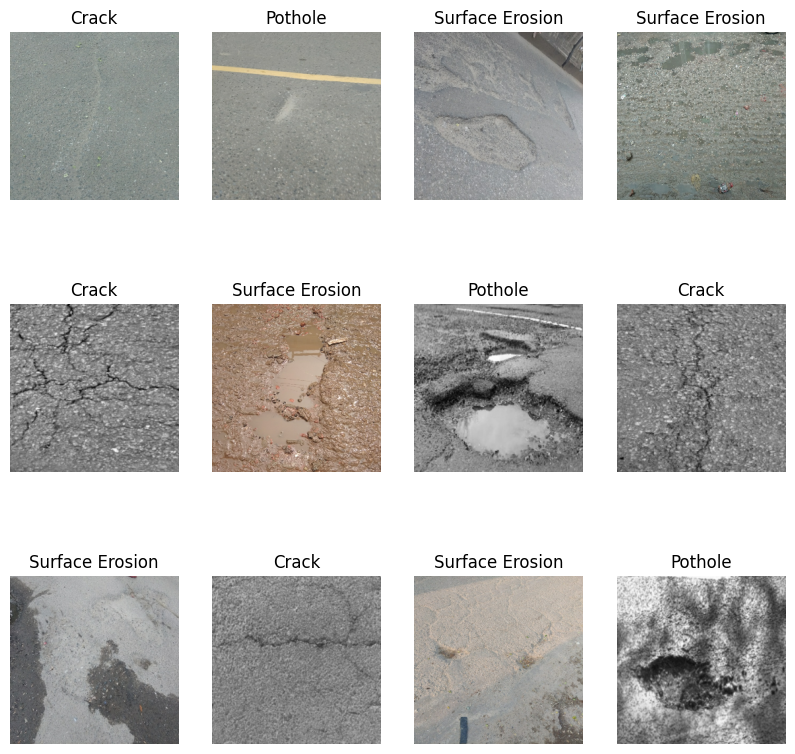

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    train_data = ds.take(train_size)
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data

train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 38
Validation data size: 4
Test data size: 6


In [9]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
])

In [12]:
n_classes = 3
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model.build(input_shape=input_shape)

e:\Python\Data Science\Road Damage\pothole_detection_CNN\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4016 - loss: 1.0823 - val_accuracy: 0.3689 - val_loss: 1.1105
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4121 - loss: 1.0706 - val_accuracy: 0.4918 - val_loss: 0.9582
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5201 - loss: 0.9485 - val_accuracy: 0.5328 - val_loss: 0.9827
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5165 - loss: 0.9502 - val_accuracy: 0.5164 - val_loss: 0.9026
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5492 - loss: 0.9053 - val_accuracy: 0.5082 - val_loss: 0.9070
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5847 - loss: 0.8595 - val_accuracy: 0.6393 - val_loss: 0.8281
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5842 - loss: 0.8378 - val_accuracy: 0.5902 - val_loss: 0.8486
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6266 - loss: 0.8134 - val_accuracy: 0.6393 - val_loss:

In [16]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.9329 - loss: 0.2451


[0.32776060700416565, 0.9114583134651184]

In [36]:
model.save("Trained Modelv2/CNN.h5")
model.save("Trained Modelv2/CNN.keras")

In [18]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [19]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [20]:
history.history['accuracy']

[0.4157024919986725,
 0.45041322708129883,
 0.5322313904762268,
 0.5429751873016357,
 0.562809944152832,
 0.5991735458374023,
 0.5809917449951172,
 0.589256227016449,
 0.6595041155815125,
 0.6512396931648254,
 0.6801652908325195,
 0.7033057808876038,
 0.7123966813087463,
 0.7074379920959473,
 0.7148760557174683,
 0.7256198525428772,
 0.7132231593132019,
 0.7371900677680969,
 0.7652892470359802,
 0.7305785417556763,
 0.7776859402656555,
 0.8090909123420715,
 0.8024793267250061,
 0.7991735339164734,
 0.8347107172012329,
 0.8033058047294617,
 0.8140496015548706,
 0.8388429880142212,
 0.828925609588623,
 0.8413223028182983,
 0.844628095626831,
 0.844628095626831,
 0.844628095626831,
 0.8719007968902588,
 0.8487603068351746,
 0.844628095626831,
 0.8685950636863708,
 0.8768594861030579,
 0.8801652789115906,
 0.8719007968902588,
 0.8834710717201233,
 0.8743801712989807,
 0.8892561793327332,
 0.8999999761581421,
 0.902479350566864,
 0.8876032829284668,
 0.9074380397796631,
 0.9008264541625977,

In [ ]:
y_true = []
y_pred = []
for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
F1 Score (macro): 0.9111569076090881
F1 Score (weighted): 0.9111956254656711

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.86      0.98      0.92        63
        Pothole       0.97      0.85      0.91        46
Surface Erosion       0.93      0.89      0.91        83

       accuracy                           0.91       192
      macro avg       0.92      0.91      0.91       192
   weighted avg       0.92      0.91      0.91       192



In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

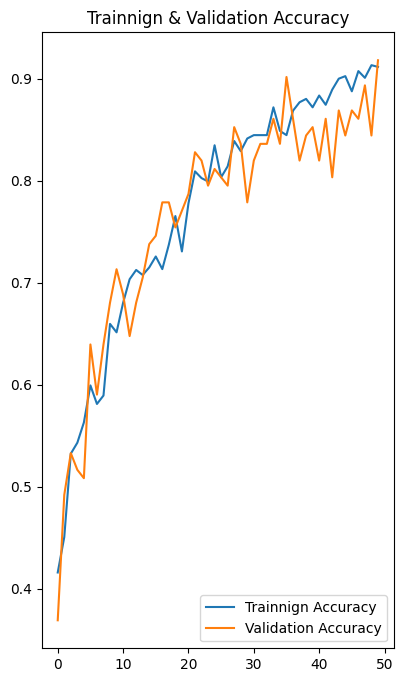

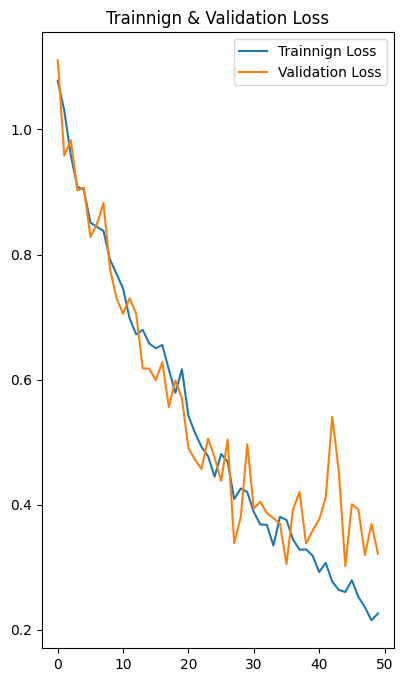

In [23]:

plt.figure(figsize = (10,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")
plt.show()
plt.figure(figsize = (10,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [24]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9161 - loss: 0.2948


[0.32776057720184326, 0.9114583134651184]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Predicted Label:  Pothole


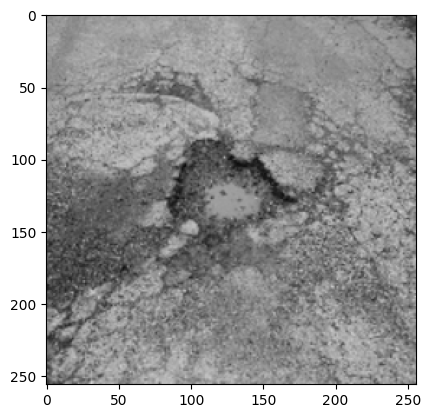

In [32]:
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()
    if brightness < 100:
        lighting = "Low light Detcted"
    elif brightness > 180:
        lighting = "High light Detcted"
    else:
        lighting = "Normal lighting Detcted"
    return predicted_class, confidence, lighting

Confidence:->99.94999694824219 Light:-> Normal lighting Detcted
Confidence:->98.58000183105469 Light:-> Normal lighting Detcted
Confidence:->87.87000274658203 Light:-> Normal lighting Detcted
Confidence:->91.73999786376953 Light:-> Low light Detcted
Confidence:->79.37999725341797 Light:-> Normal lighting Detcted
Confidence:->56.36000061035156 Light:-> Normal lighting Detcted
Confidence:->99.19000244140625 Light:-> Normal lighting Detcted
Confidence:->100.0 Light:-> Normal lighting Detcted
Confidence:->100.0 Light:-> Normal lighting Detcted


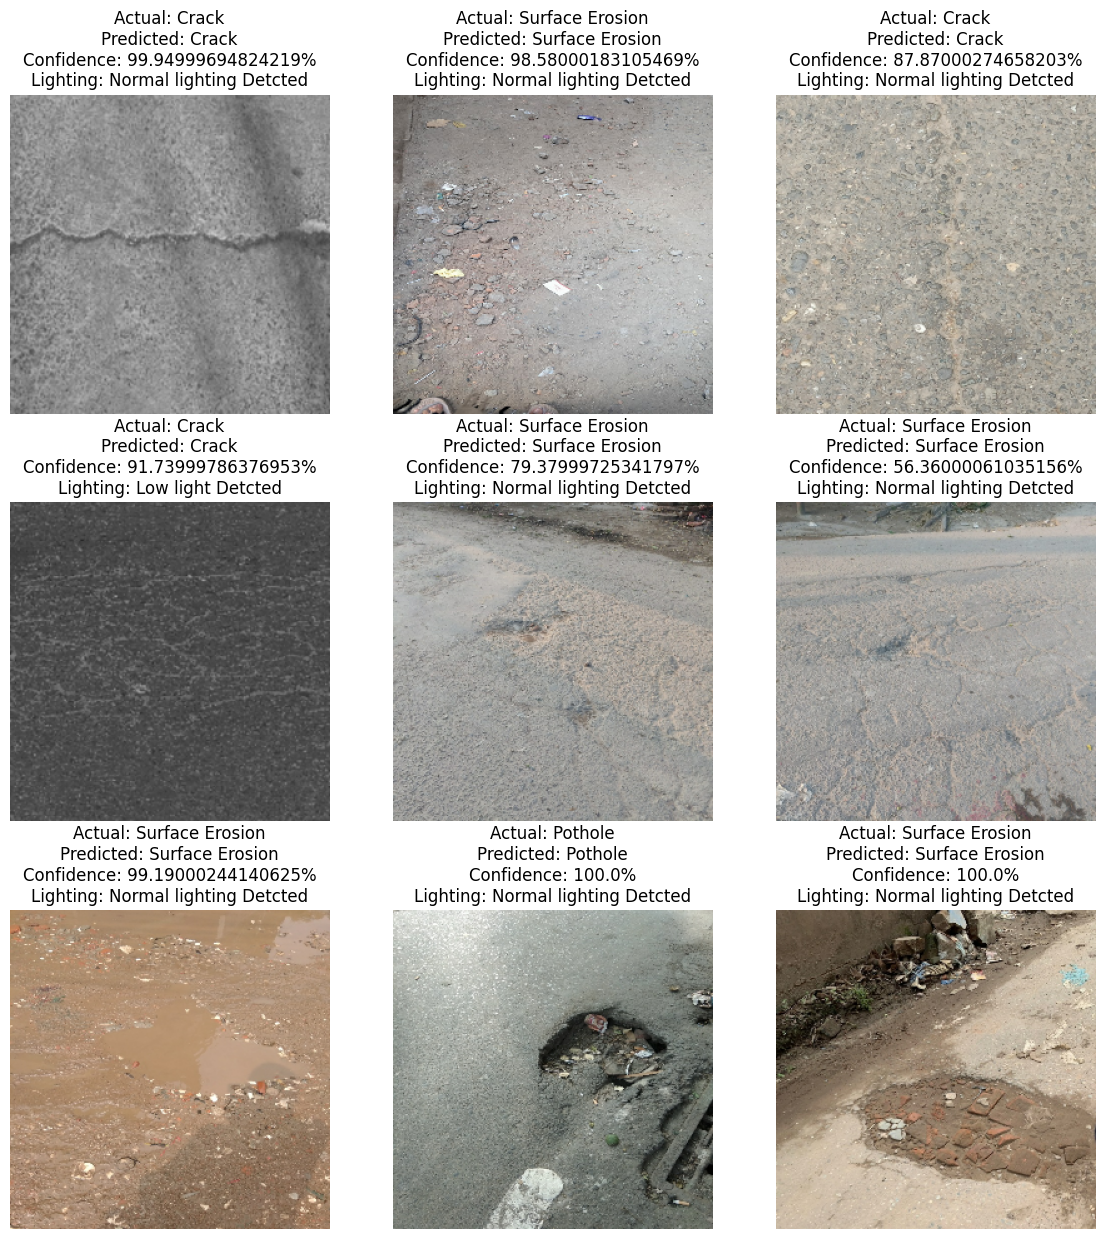

In [41]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [52]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")

Prediction: 0, Confidence: 100.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


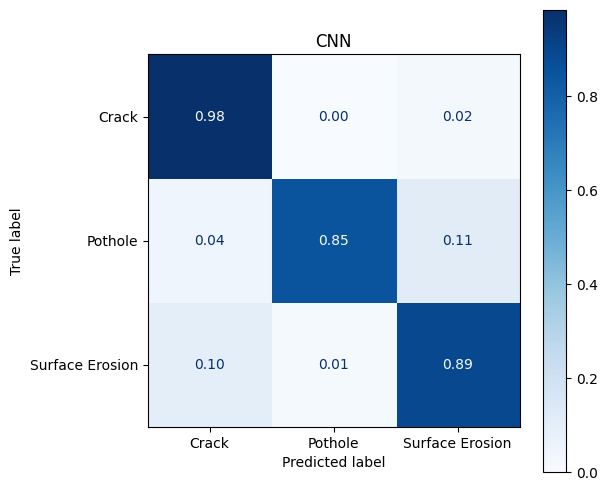

In [96]:

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("CNN")
plt.savefig("Confusion Matrx/CNNx.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)

conv2d
conv2d_1
conv2d_2
conv2d_3
conv2d_4
conv2d_5
